# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = layers.Conv2D(filters=filters, kernel_size=(5,5), strides=(1,1) ,
                      padding='same', activation='relu')(input_layer)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_12/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_14/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_16/batchnorm/add_1:0", s

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0002
batch_size = 40
num_epochs = 100
num_img_train = 6435
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 161
Validation steps: 30


Epoch 1/100
160/161 [============================>.] - ETA: 1s - loss: 0.9709

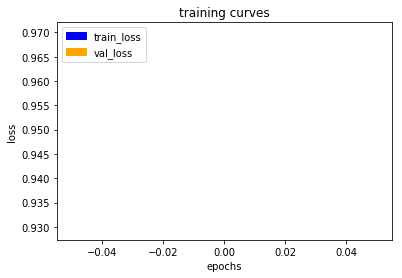

161/161 [==============================] - 321s - loss: 0.9699 - val_loss: 0.9294
Epoch 2/100
160/161 [============================>.] - ETA: 1s - loss: 0.6385

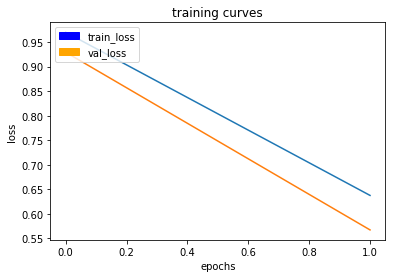

161/161 [==============================] - 320s - loss: 0.6376 - val_loss: 0.5675
Epoch 3/100
160/161 [============================>.] - ETA: 1s - loss: 0.3632

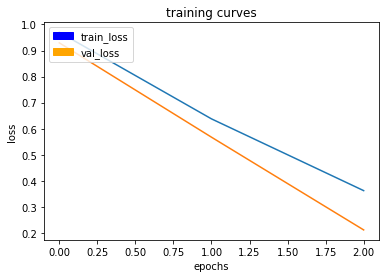

161/161 [==============================] - 320s - loss: 0.3625 - val_loss: 0.2118
Epoch 4/100
160/161 [============================>.] - ETA: 1s - loss: 0.2116

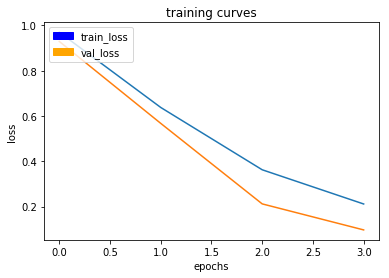

161/161 [==============================] - 319s - loss: 0.2113 - val_loss: 0.0968
Epoch 5/100
160/161 [============================>.] - ETA: 1s - loss: 0.1349

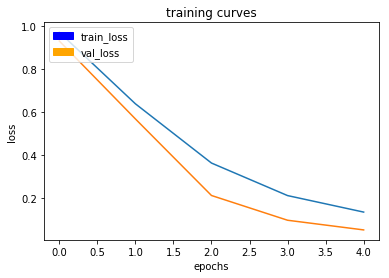

161/161 [==============================] - 319s - loss: 0.1346 - val_loss: 0.0519
Epoch 6/100
160/161 [============================>.] - ETA: 1s - loss: 0.0927

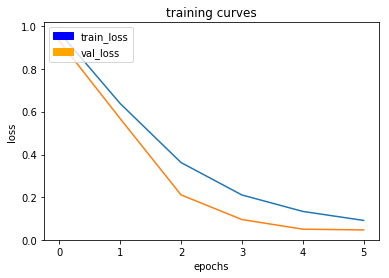

161/161 [==============================] - 319s - loss: 0.0926 - val_loss: 0.0484
Epoch 7/100
160/161 [============================>.] - ETA: 1s - loss: 0.0946

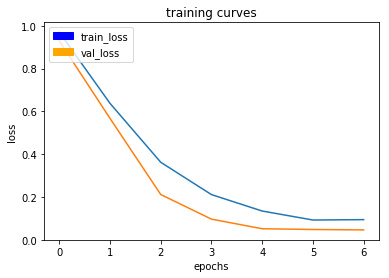

161/161 [==============================] - 319s - loss: 0.0944 - val_loss: 0.0464
Epoch 8/100
160/161 [============================>.] - ETA: 1s - loss: 0.0608

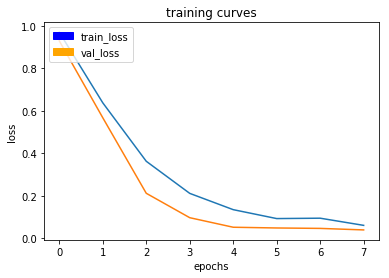

161/161 [==============================] - 319s - loss: 0.0607 - val_loss: 0.0393
Epoch 9/100
160/161 [============================>.] - ETA: 1s - loss: 0.0502

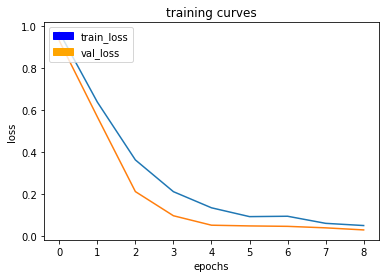

161/161 [==============================] - 319s - loss: 0.0502 - val_loss: 0.0294
Epoch 10/100
160/161 [============================>.] - ETA: 1s - loss: 0.0425

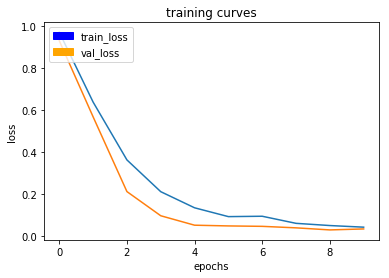

161/161 [==============================] - 320s - loss: 0.0424 - val_loss: 0.0341
Epoch 11/100
160/161 [============================>.] - ETA: 1s - loss: 0.0374

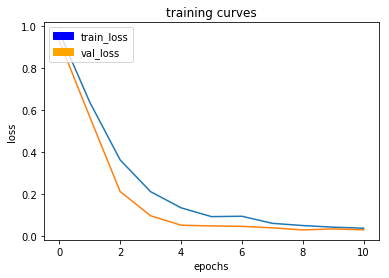

161/161 [==============================] - 319s - loss: 0.0374 - val_loss: 0.0302
Epoch 12/100
160/161 [============================>.] - ETA: 1s - loss: 0.0339

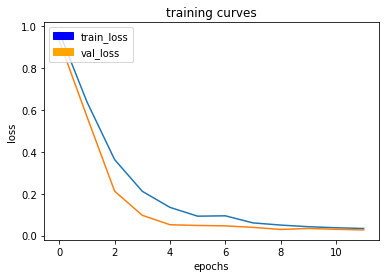

161/161 [==============================] - 319s - loss: 0.0339 - val_loss: 0.0271
Epoch 13/100
160/161 [============================>.] - ETA: 1s - loss: 0.0299

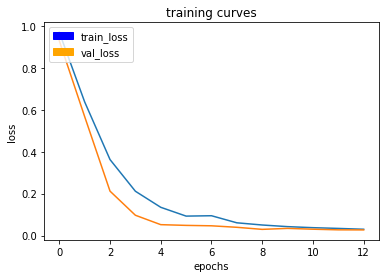

161/161 [==============================] - 320s - loss: 0.0299 - val_loss: 0.0268
Epoch 14/100
160/161 [============================>.] - ETA: 1s - loss: 0.0272

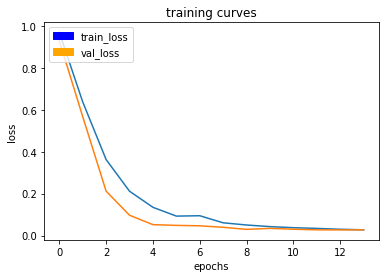

161/161 [==============================] - 320s - loss: 0.0272 - val_loss: 0.0273
Epoch 15/100
160/161 [============================>.] - ETA: 1s - loss: 0.0249

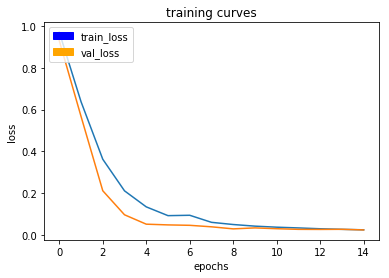

161/161 [==============================] - 320s - loss: 0.0249 - val_loss: 0.0244
Epoch 16/100
160/161 [============================>.] - ETA: 1s - loss: 0.0232

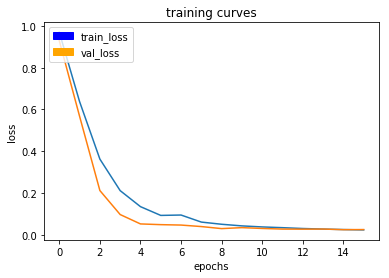

161/161 [==============================] - 319s - loss: 0.0232 - val_loss: 0.0248
Epoch 17/100
160/161 [============================>.] - ETA: 1s - loss: 0.0218

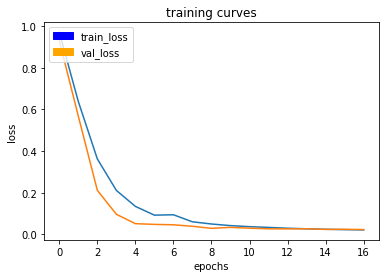

161/161 [==============================] - 320s - loss: 0.0218 - val_loss: 0.0235
Epoch 18/100
160/161 [============================>.] - ETA: 1s - loss: 0.0305

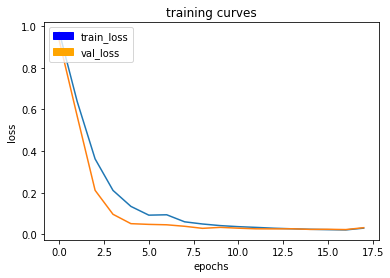

161/161 [==============================] - 320s - loss: 0.0304 - val_loss: 0.0325
Epoch 19/100
160/161 [============================>.] - ETA: 1s - loss: 0.0267

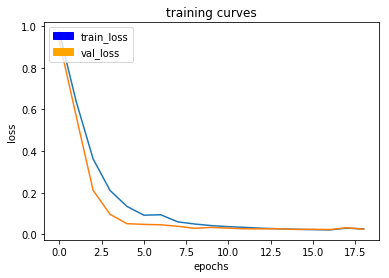

161/161 [==============================] - 319s - loss: 0.0266 - val_loss: 0.0249
Epoch 20/100
160/161 [============================>.] - ETA: 1s - loss: 0.0224

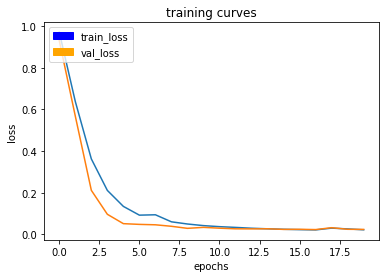

161/161 [==============================] - 320s - loss: 0.0224 - val_loss: 0.0243
Epoch 21/100
160/161 [============================>.] - ETA: 1s - loss: 0.0203

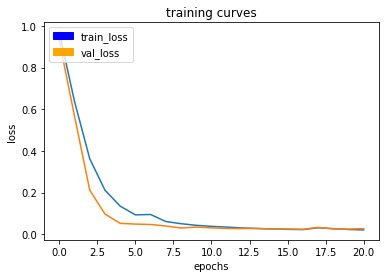

161/161 [==============================] - 319s - loss: 0.0203 - val_loss: 0.0269
Epoch 22/100
160/161 [============================>.] - ETA: 1s - loss: 0.0193

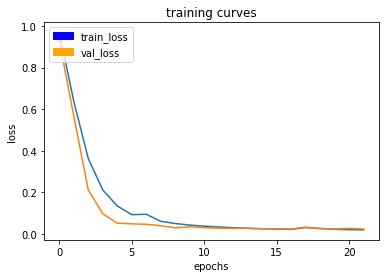

161/161 [==============================] - 320s - loss: 0.0193 - val_loss: 0.0237
Epoch 23/100
160/161 [============================>.] - ETA: 1s - loss: 0.0180

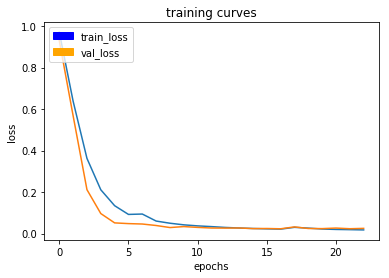

161/161 [==============================] - 320s - loss: 0.0180 - val_loss: 0.0254
Epoch 24/100
160/161 [============================>.] - ETA: 1s - loss: 0.0173

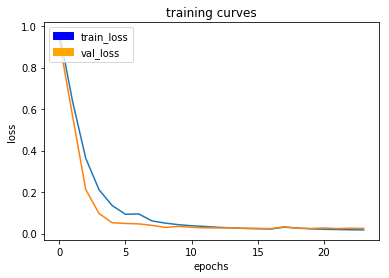

161/161 [==============================] - 320s - loss: 0.0173 - val_loss: 0.0246
Epoch 25/100
160/161 [============================>.] - ETA: 1s - loss: 0.0174

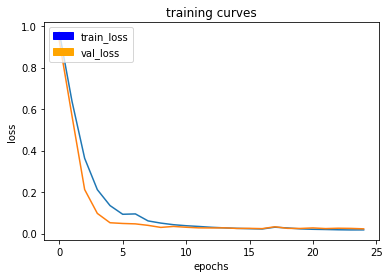

161/161 [==============================] - 319s - loss: 0.0174 - val_loss: 0.0225
Epoch 26/100
160/161 [============================>.] - ETA: 1s - loss: 0.0161

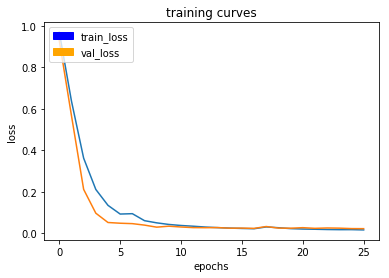

161/161 [==============================] - 320s - loss: 0.0161 - val_loss: 0.0221
Epoch 27/100
160/161 [============================>.] - ETA: 1s - loss: 0.0156

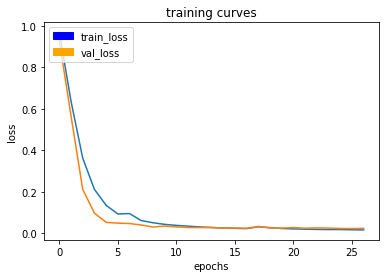

161/161 [==============================] - 319s - loss: 0.0156 - val_loss: 0.0229
Epoch 28/100
160/161 [============================>.] - ETA: 1s - loss: 0.0148

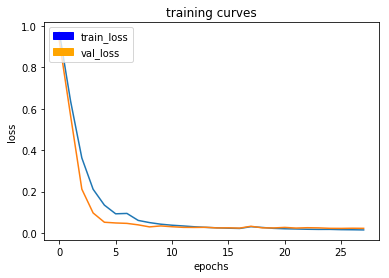

161/161 [==============================] - 319s - loss: 0.0148 - val_loss: 0.0224
Epoch 29/100
160/161 [============================>.] - ETA: 1s - loss: 0.0143

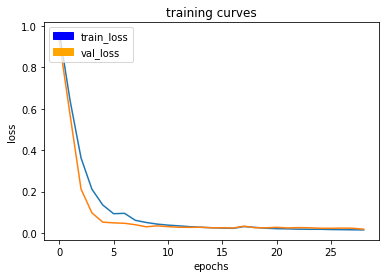

161/161 [==============================] - 320s - loss: 0.0143 - val_loss: 0.0179
Epoch 30/100
160/161 [============================>.] - ETA: 1s - loss: 0.0139

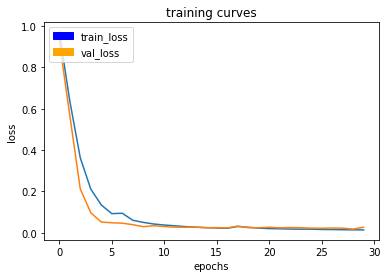

161/161 [==============================] - 320s - loss: 0.0139 - val_loss: 0.0269
Epoch 31/100
160/161 [============================>.] - ETA: 1s - loss: 0.0136

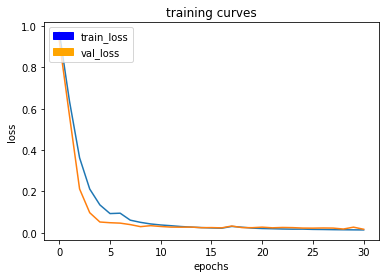

161/161 [==============================] - 319s - loss: 0.0136 - val_loss: 0.0167
Epoch 32/100
160/161 [============================>.] - ETA: 1s - loss: 0.0138

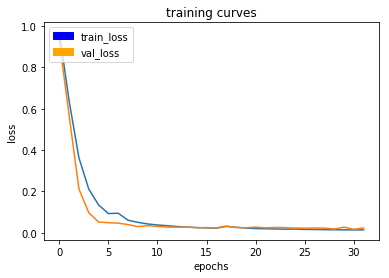

161/161 [==============================] - 320s - loss: 0.0138 - val_loss: 0.0232
Epoch 33/100
160/161 [============================>.] - ETA: 1s - loss: 0.0133

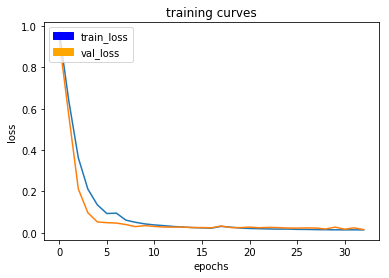

161/161 [==============================] - 319s - loss: 0.0133 - val_loss: 0.0151
Epoch 34/100
160/161 [============================>.] - ETA: 1s - loss: 0.0127

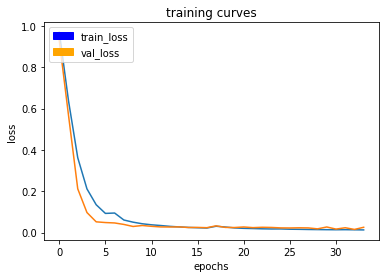

161/161 [==============================] - 319s - loss: 0.0127 - val_loss: 0.0255
Epoch 35/100
160/161 [============================>.] - ETA: 1s - loss: 0.0123

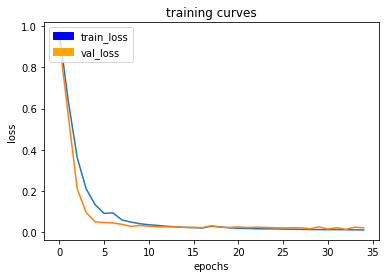

161/161 [==============================] - 319s - loss: 0.0123 - val_loss: 0.0226
Epoch 36/100
160/161 [============================>.] - ETA: 1s - loss: 0.0119

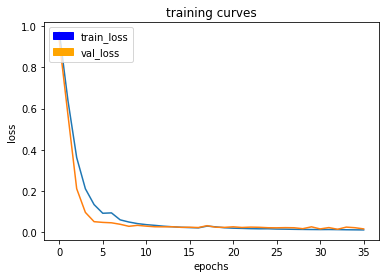

161/161 [==============================] - 319s - loss: 0.0119 - val_loss: 0.0169
Epoch 37/100
160/161 [============================>.] - ETA: 1s - loss: 0.0117

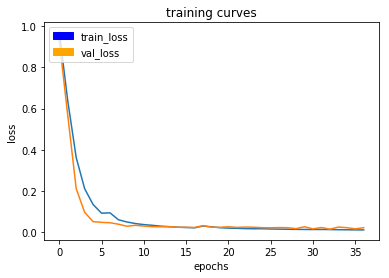

161/161 [==============================] - 319s - loss: 0.0116 - val_loss: 0.0223
Epoch 38/100
160/161 [============================>.] - ETA: 1s - loss: 0.0114

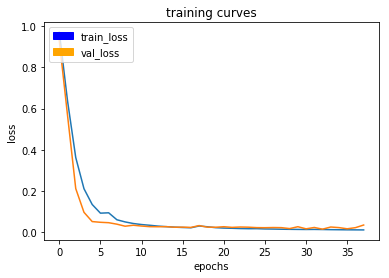

161/161 [==============================] - 320s - loss: 0.0114 - val_loss: 0.0351
Epoch 39/100
160/161 [============================>.] - ETA: 1s - loss: 0.0112

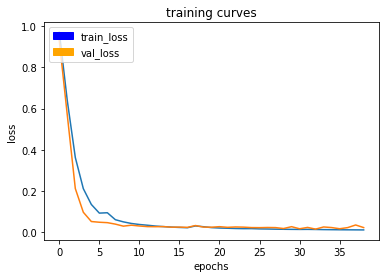

161/161 [==============================] - 318s - loss: 0.0112 - val_loss: 0.0225
Epoch 40/100
160/161 [============================>.] - ETA: 1s - loss: 0.0122

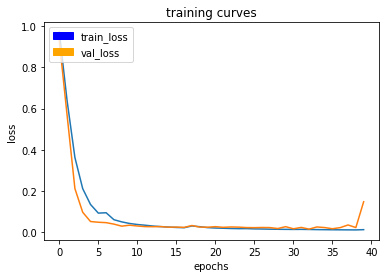

161/161 [==============================] - 319s - loss: 0.0125 - val_loss: 0.1479
Epoch 41/100
160/161 [============================>.] - ETA: 1s - loss: 0.0196

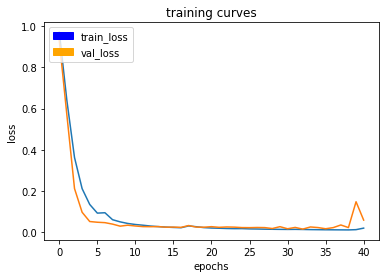

161/161 [==============================] - 319s - loss: 0.0199 - val_loss: 0.0588
Epoch 42/100
160/161 [============================>.] - ETA: 1s - loss: 0.0183

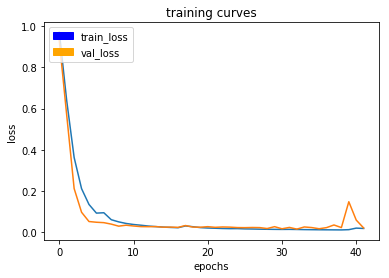

161/161 [==============================] - 320s - loss: 0.0182 - val_loss: 0.0205
Epoch 43/100
160/161 [============================>.] - ETA: 1s - loss: 0.0136

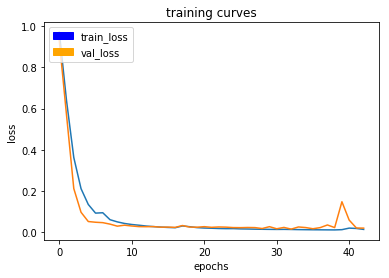

161/161 [==============================] - 319s - loss: 0.0136 - val_loss: 0.0199
Epoch 44/100
160/161 [============================>.] - ETA: 1s - loss: 0.0123

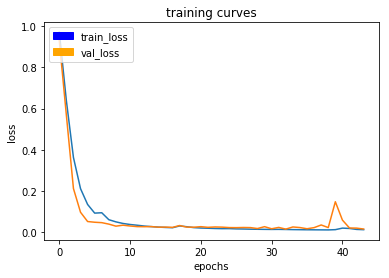

161/161 [==============================] - 319s - loss: 0.0123 - val_loss: 0.0155
Epoch 45/100
160/161 [============================>.] - ETA: 1s - loss: 0.0116

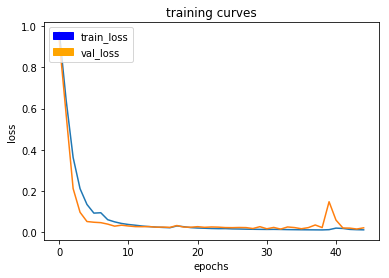

161/161 [==============================] - 320s - loss: 0.0116 - val_loss: 0.0213
Epoch 46/100
160/161 [============================>.] - ETA: 1s - loss: 0.0111

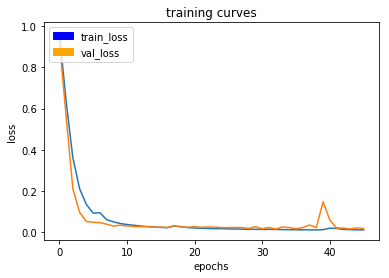

161/161 [==============================] - 320s - loss: 0.0111 - val_loss: 0.0179
Epoch 47/100
160/161 [============================>.] - ETA: 1s - loss: 0.0107

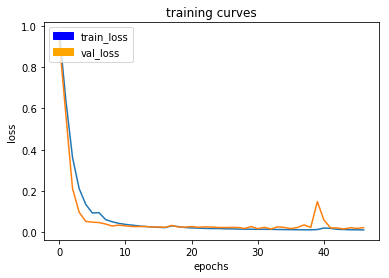

161/161 [==============================] - 320s - loss: 0.0107 - val_loss: 0.0218
Epoch 48/100
160/161 [============================>.] - ETA: 1s - loss: 0.0104

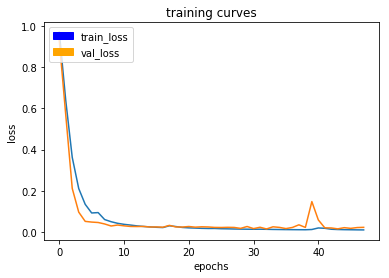

161/161 [==============================] - 319s - loss: 0.0104 - val_loss: 0.0229
Epoch 49/100
160/161 [============================>.] - ETA: 1s - loss: 0.0101

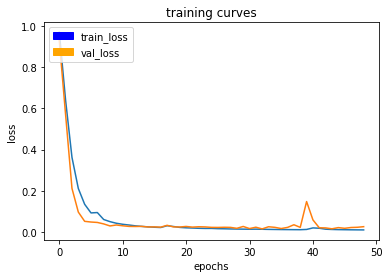

161/161 [==============================] - 320s - loss: 0.0101 - val_loss: 0.0259
Epoch 50/100
160/161 [============================>.] - ETA: 1s - loss: 0.0099

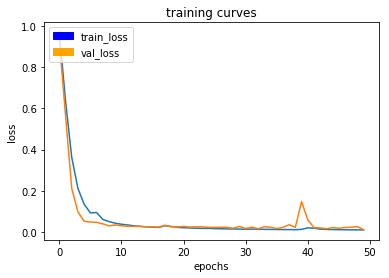

161/161 [==============================] - 319s - loss: 0.0099 - val_loss: 0.0109
Epoch 51/100
160/161 [============================>.] - ETA: 1s - loss: 0.0097

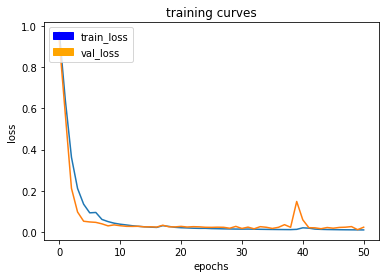

161/161 [==============================] - 319s - loss: 0.0097 - val_loss: 0.0228
Epoch 52/100
160/161 [============================>.] - ETA: 1s - loss: 0.0095

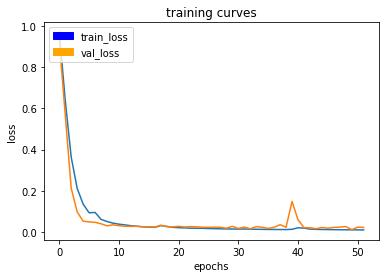

161/161 [==============================] - 319s - loss: 0.0095 - val_loss: 0.0216
Epoch 53/100
160/161 [============================>.] - ETA: 1s - loss: 0.0093

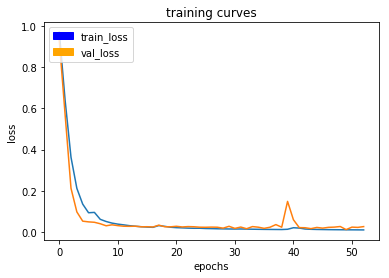

161/161 [==============================] - 318s - loss: 0.0093 - val_loss: 0.0254
Epoch 54/100
160/161 [============================>.] - ETA: 1s - loss: 0.0092

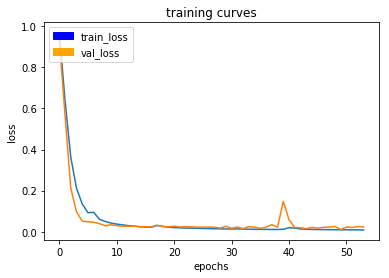

161/161 [==============================] - 320s - loss: 0.0092 - val_loss: 0.0234
Epoch 55/100
160/161 [============================>.] - ETA: 1s - loss: 0.0090

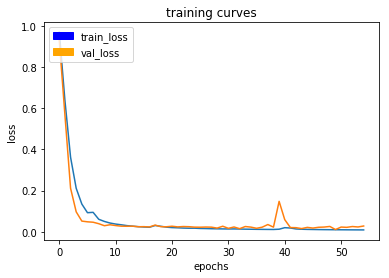

161/161 [==============================] - 320s - loss: 0.0090 - val_loss: 0.0280
Epoch 56/100
160/161 [============================>.] - ETA: 1s - loss: 0.0088

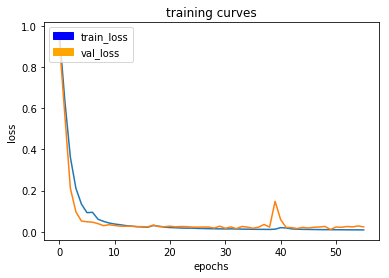

161/161 [==============================] - 320s - loss: 0.0088 - val_loss: 0.0236
Epoch 57/100
160/161 [============================>.] - ETA: 1s - loss: 0.0087

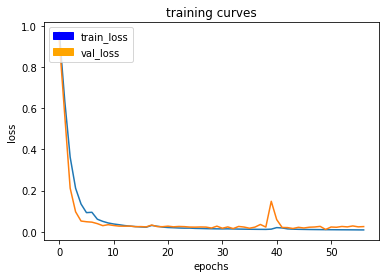

161/161 [==============================] - 319s - loss: 0.0086 - val_loss: 0.0248
Epoch 58/100
160/161 [============================>.] - ETA: 1s - loss: 0.0085

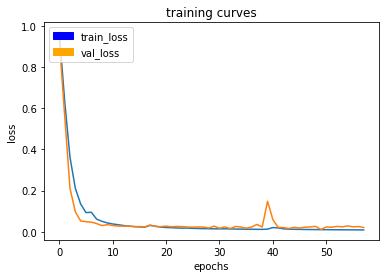

161/161 [==============================] - 318s - loss: 0.0085 - val_loss: 0.0205
Epoch 59/100
160/161 [============================>.] - ETA: 1s - loss: 0.0083

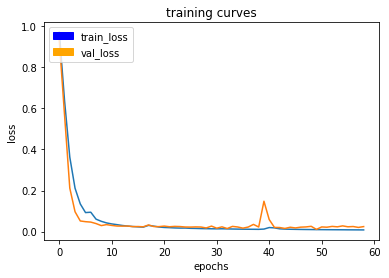

161/161 [==============================] - 320s - loss: 0.0083 - val_loss: 0.0245
Epoch 60/100
160/161 [============================>.] - ETA: 1s - loss: 0.0082

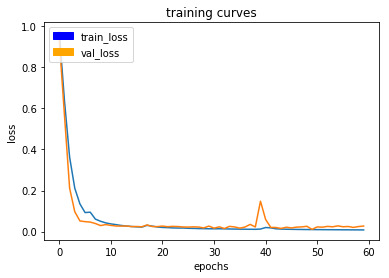

161/161 [==============================] - 319s - loss: 0.0082 - val_loss: 0.0270
Epoch 61/100
160/161 [============================>.] - ETA: 1s - loss: 0.0082

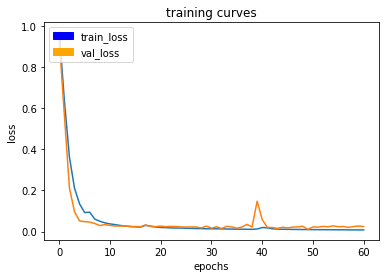

161/161 [==============================] - 319s - loss: 0.0082 - val_loss: 0.0246
Epoch 62/100
160/161 [============================>.] - ETA: 1s - loss: 0.0080

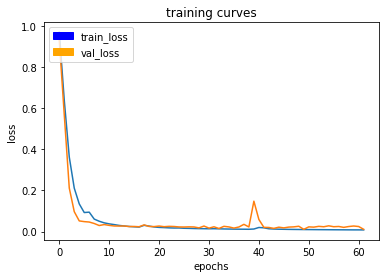

161/161 [==============================] - 320s - loss: 0.0080 - val_loss: 0.0110
Epoch 63/100
160/161 [============================>.] - ETA: 1s - loss: 0.0078

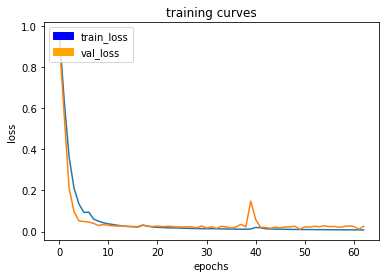

161/161 [==============================] - 319s - loss: 0.0078 - val_loss: 0.0254
Epoch 64/100
160/161 [============================>.] - ETA: 1s - loss: 0.0077

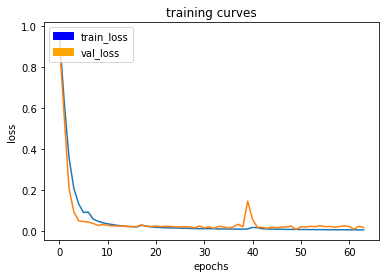

161/161 [==============================] - 319s - loss: 0.0077 - val_loss: 0.0193
Epoch 65/100
160/161 [============================>.] - ETA: 1s - loss: 0.0075

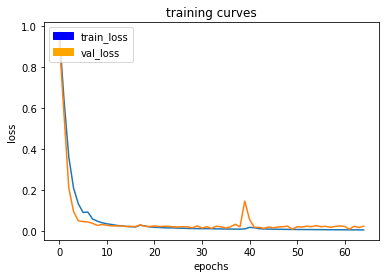

161/161 [==============================] - 320s - loss: 0.0075 - val_loss: 0.0257
Epoch 66/100
160/161 [============================>.] - ETA: 1s - loss: 0.0074

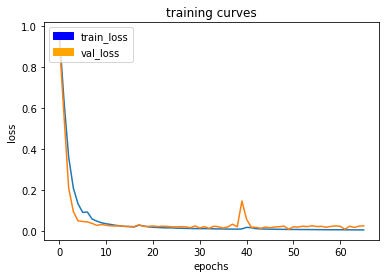

161/161 [==============================] - 320s - loss: 0.0074 - val_loss: 0.0274
Epoch 67/100
160/161 [============================>.] - ETA: 1s - loss: 0.0073

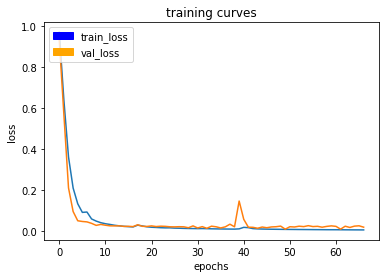

161/161 [==============================] - 320s - loss: 0.0073 - val_loss: 0.0206
Epoch 68/100
160/161 [============================>.] - ETA: 1s - loss: 0.0072

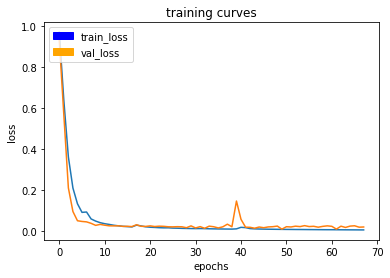

161/161 [==============================] - 320s - loss: 0.0072 - val_loss: 0.0215
Epoch 69/100
160/161 [============================>.] - ETA: 1s - loss: 0.0071

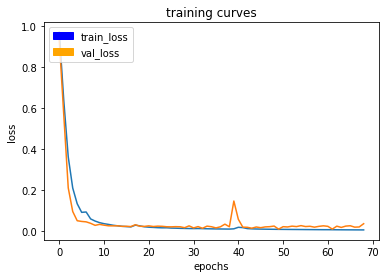

161/161 [==============================] - 319s - loss: 0.0071 - val_loss: 0.0373
Epoch 70/100
160/161 [============================>.] - ETA: 1s - loss: 0.0071

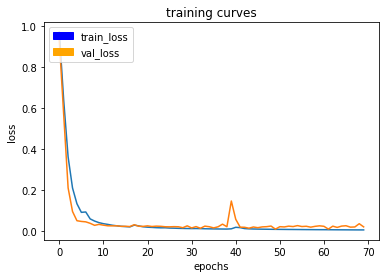

161/161 [==============================] - 319s - loss: 0.0071 - val_loss: 0.0218
Epoch 71/100
160/161 [============================>.] - ETA: 1s - loss: 0.0070

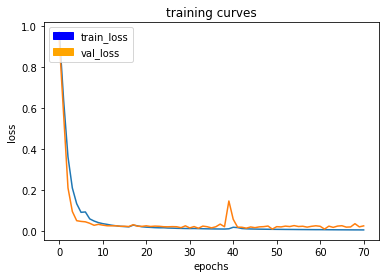

161/161 [==============================] - 320s - loss: 0.0069 - val_loss: 0.0267
Epoch 72/100
160/161 [============================>.] - ETA: 1s - loss: 0.0088

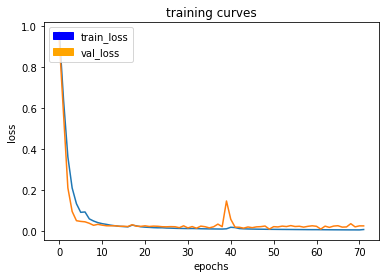

161/161 [==============================] - 320s - loss: 0.0088 - val_loss: 0.0265
Epoch 73/100
160/161 [============================>.] - ETA: 1s - loss: 0.0152

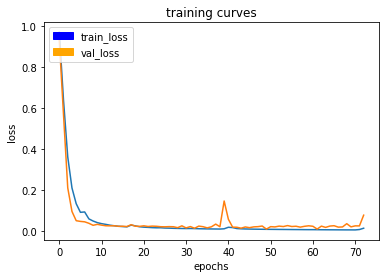

161/161 [==============================] - 319s - loss: 0.0152 - val_loss: 0.0787
Epoch 74/100
160/161 [============================>.] - ETA: 1s - loss: 0.0118

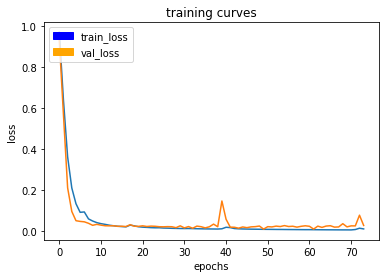

161/161 [==============================] - 320s - loss: 0.0118 - val_loss: 0.0287
Epoch 75/100
160/161 [============================>.] - ETA: 1s - loss: 0.0095

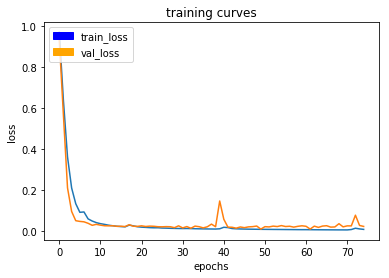

161/161 [==============================] - 320s - loss: 0.0095 - val_loss: 0.0239
Epoch 76/100
160/161 [============================>.] - ETA: 1s - loss: 0.0086

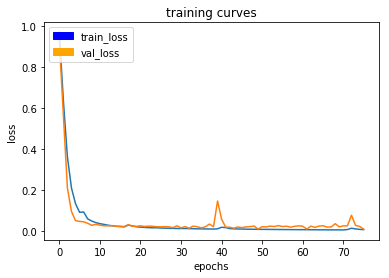

161/161 [==============================] - 319s - loss: 0.0086 - val_loss: 0.0107
Epoch 77/100
160/161 [============================>.] - ETA: 1s - loss: 0.0080

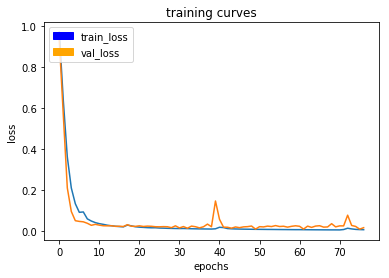

161/161 [==============================] - 320s - loss: 0.0080 - val_loss: 0.0178
Epoch 78/100
160/161 [============================>.] - ETA: 1s - loss: 0.0076

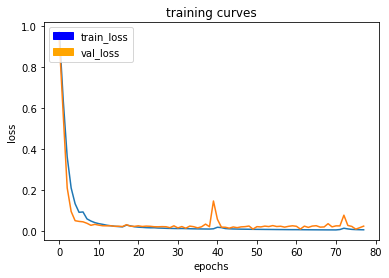

161/161 [==============================] - 320s - loss: 0.0076 - val_loss: 0.0253
Epoch 79/100
160/161 [============================>.] - ETA: 1s - loss: 0.0073

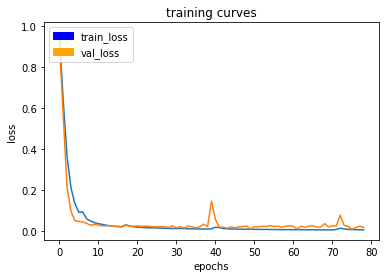

161/161 [==============================] - 320s - loss: 0.0073 - val_loss: 0.0185
Epoch 80/100
160/161 [============================>.] - ETA: 1s - loss: 0.0071

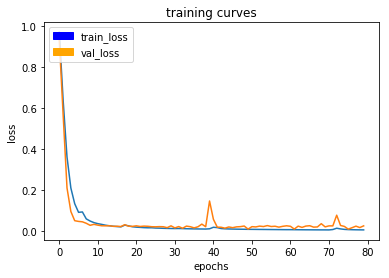

161/161 [==============================] - 319s - loss: 0.0071 - val_loss: 0.0267
Epoch 81/100
160/161 [============================>.] - ETA: 1s - loss: 0.0068

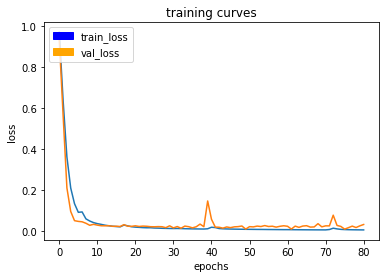

161/161 [==============================] - 320s - loss: 0.0068 - val_loss: 0.0332
Epoch 82/100
160/161 [============================>.] - ETA: 1s - loss: 0.0067

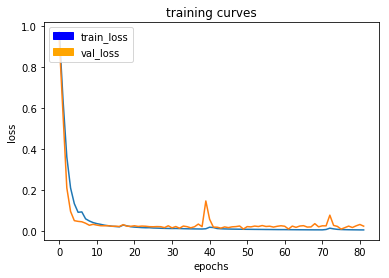

161/161 [==============================] - 319s - loss: 0.0067 - val_loss: 0.0250
Epoch 83/100
160/161 [============================>.] - ETA: 1s - loss: 0.0066

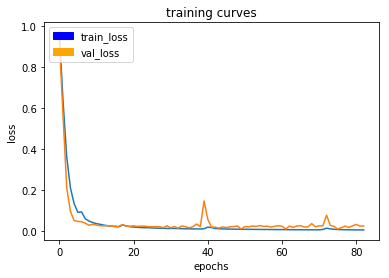

161/161 [==============================] - 319s - loss: 0.0066 - val_loss: 0.0262
Epoch 84/100
160/161 [============================>.] - ETA: 1s - loss: 0.0065

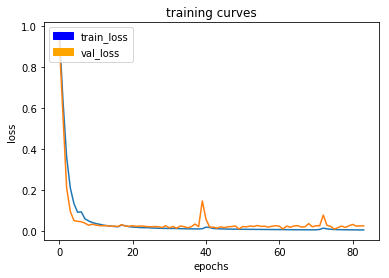

161/161 [==============================] - 319s - loss: 0.0065 - val_loss: 0.0261
Epoch 85/100
160/161 [============================>.] - ETA: 1s - loss: 0.0064

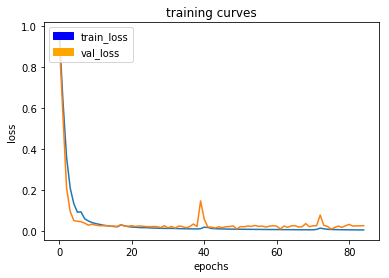

161/161 [==============================] - 320s - loss: 0.0064 - val_loss: 0.0273
Epoch 86/100
160/161 [============================>.] - ETA: 1s - loss: 0.0063

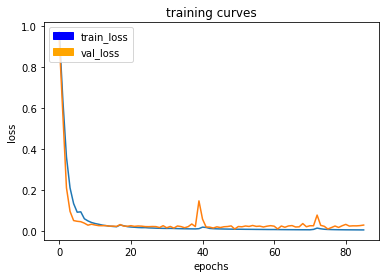

161/161 [==============================] - 320s - loss: 0.0063 - val_loss: 0.0299
Epoch 87/100
160/161 [============================>.] - ETA: 1s - loss: 0.0062

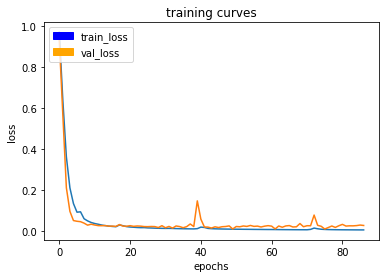

161/161 [==============================] - 320s - loss: 0.0062 - val_loss: 0.0279
Epoch 88/100
160/161 [============================>.] - ETA: 1s - loss: 0.0062

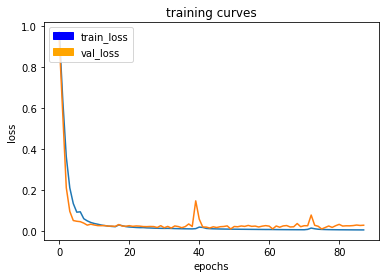

161/161 [==============================] - 319s - loss: 0.0062 - val_loss: 0.0290
Epoch 89/100
160/161 [============================>.] - ETA: 1s - loss: 0.0061

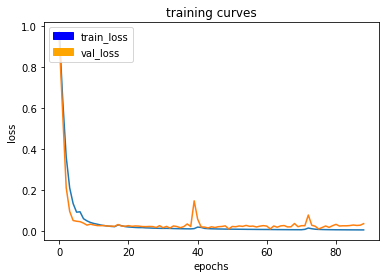

161/161 [==============================] - 320s - loss: 0.0061 - val_loss: 0.0366
Epoch 90/100
160/161 [============================>.] - ETA: 1s - loss: 0.0060

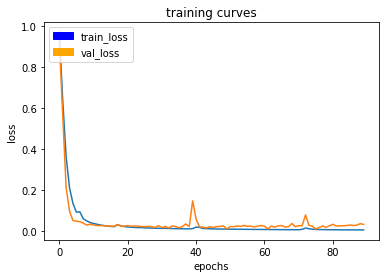

161/161 [==============================] - 319s - loss: 0.0060 - val_loss: 0.0327
Epoch 91/100
160/161 [============================>.] - ETA: 1s - loss: 0.0060

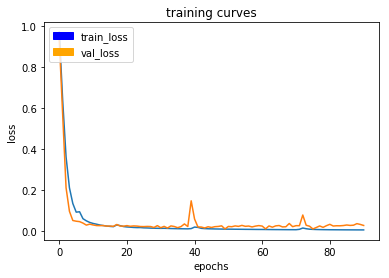

161/161 [==============================] - 319s - loss: 0.0060 - val_loss: 0.0277
Epoch 92/100
160/161 [============================>.] - ETA: 1s - loss: 0.0059

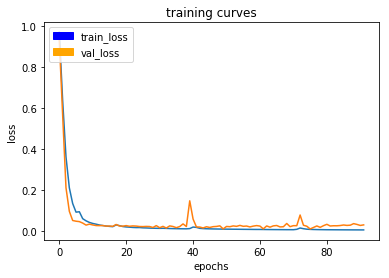

161/161 [==============================] - 320s - loss: 0.0059 - val_loss: 0.0304
Epoch 93/100
160/161 [============================>.] - ETA: 1s - loss: 0.0058

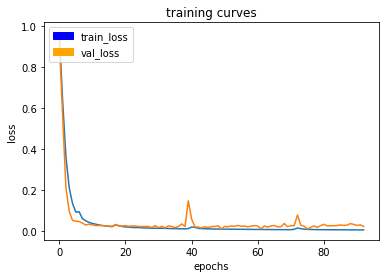

161/161 [==============================] - 319s - loss: 0.0058 - val_loss: 0.0228
Epoch 94/100
160/161 [============================>.] - ETA: 1s - loss: 0.0058

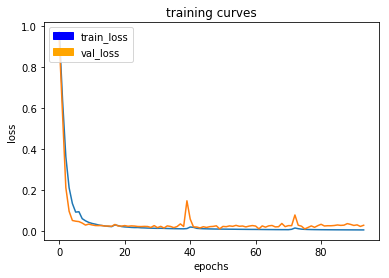

161/161 [==============================] - 319s - loss: 0.0058 - val_loss: 0.0285
Epoch 95/100
160/161 [============================>.] - ETA: 1s - loss: 0.0058

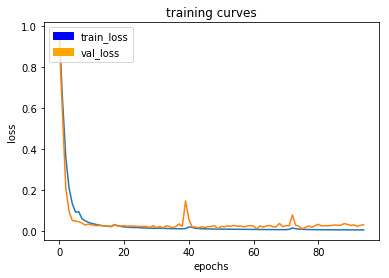

161/161 [==============================] - 319s - loss: 0.0058 - val_loss: 0.0307
Epoch 96/100
160/161 [============================>.] - ETA: 1s - loss: 0.0057

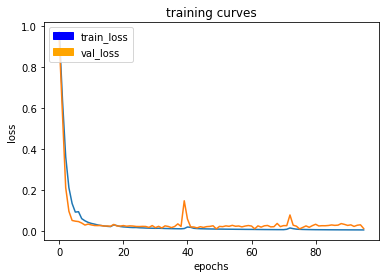

161/161 [==============================] - 319s - loss: 0.0057 - val_loss: 0.0124
Epoch 97/100
160/161 [============================>.] - ETA: 1s - loss: 0.0057

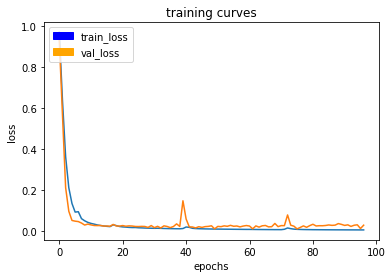

161/161 [==============================] - 320s - loss: 0.0057 - val_loss: 0.0287
Epoch 98/100
160/161 [============================>.] - ETA: 1s - loss: 0.0056

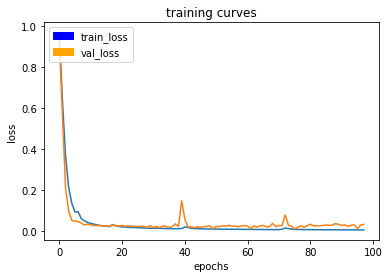

161/161 [==============================] - 320s - loss: 0.0056 - val_loss: 0.0328
Epoch 99/100
160/161 [============================>.] - ETA: 1s - loss: 0.0055

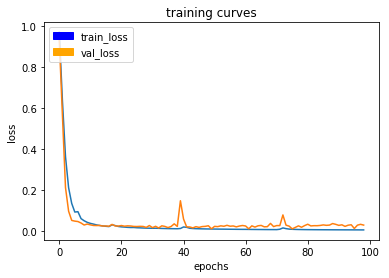

161/161 [==============================] - 320s - loss: 0.0055 - val_loss: 0.0290
Epoch 100/100
160/161 [============================>.] - ETA: 1s - loss: 0.0055

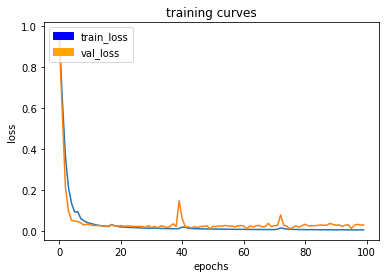

161/161 [==============================] - 319s - loss: 0.0055 - val_loss: 0.0292


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

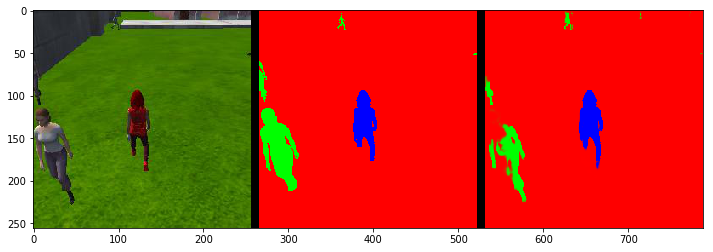

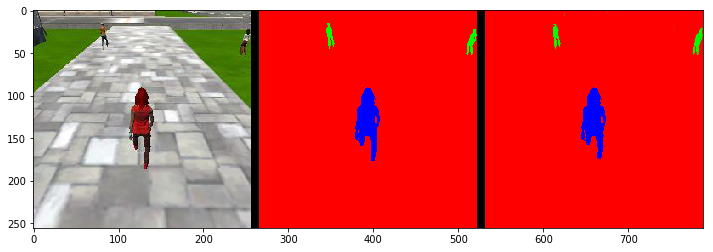

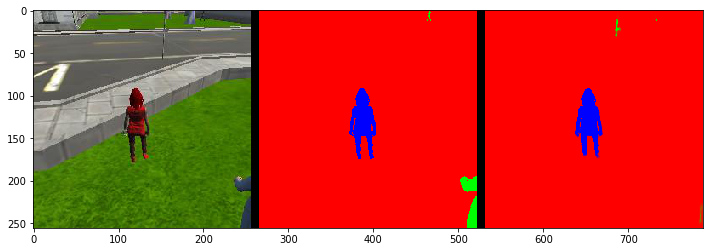

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

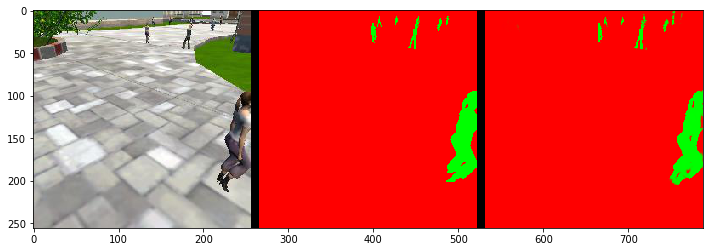

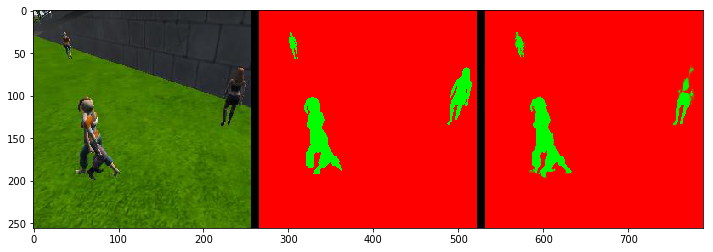

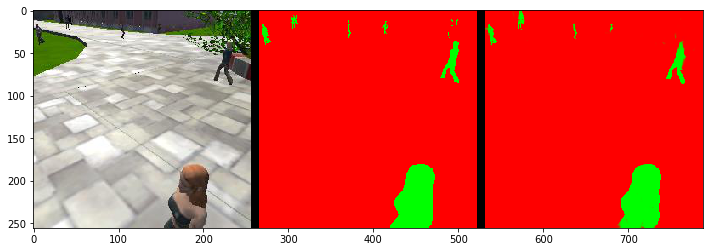

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

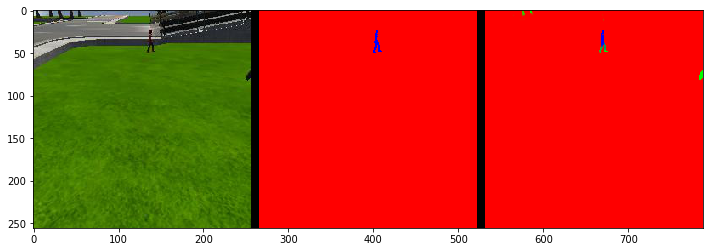

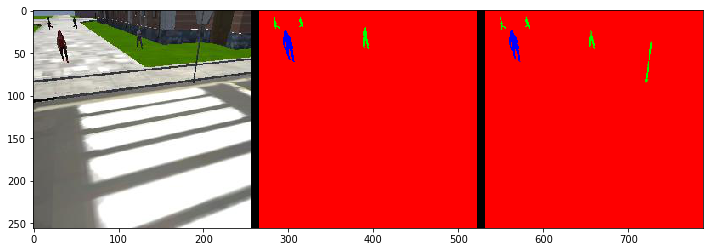

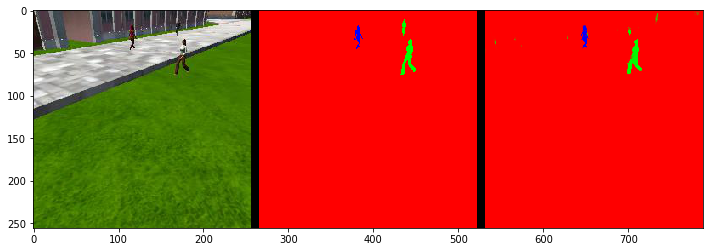

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9975092679390832
average intersection over union for other people is 0.4540885232374562
average intersection over union for the hero is 0.9624302353773121
number true positives: 539, number false positives: 1, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9908646621199241
average intersection over union for other people is 0.8228469541272989
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 28, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9977242225036357
average intersection over union for other people is 0.5624772384600755
average intersection over union for the hero is 0.41772076524666873
number true positives: 175, number false positives: 1, number false negatives: 137


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.8104426787741204


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.690075500312


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.559266637029
